<a href="https://colab.research.google.com/github/michiko-tamon/OII-Statistics/blob/main/notebooks/example-2.75/example-2.7-answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Example 2.75
============

This notebook is available on github
[here](https://github.com/aezarebski/aas-extended-examples). If you find
errors or would like to suggest an improvement, feel free to create an
issue.

As usual we will start by importing some useful libraries.

In [1]:
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Today we will look at a dataset from a double-blind clinical trial of a new treatment for rheumatoid arthritis. We will test whether treatment is correlated with a change in symptoms using a $\chi^{2}$-test.

First, we need to load the data which comes bundled with `statsmodels`.

In [2]:
ra = sm.datasets.get_rdataset("Arthritis", "vcd").data #load the data from statsmodels
ra.head()

,ID,Treatment,Sex,Age,Improved
0,57,Treated,Male,27,Some
1,46,Treated,Male,29,None
2,77,Treated,Male,30,None
3,17,Treated,Male,32,Marked
4,36,Treated,Male,46,Marked


### Question

Use `pandas` to generate a cross tabulation of the treatment status and improvement.

[hint](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html)

### Answer

In [4]:
outcome_tbl = pd.crosstab(ra.Treatment, ra.Improved) #cross table between treatment and improved 
print(outcome_tbl)

Improved   Marked  None  Some
Treatment                    
Placebo         7    29     7
Treated        21    13     7


### Question

Generate a mosaic plot to display this data.

[hint](https://www.statsmodels.org/dev/generated/statsmodels.graphics.mosaicplot.mosaic.html)

### Answer

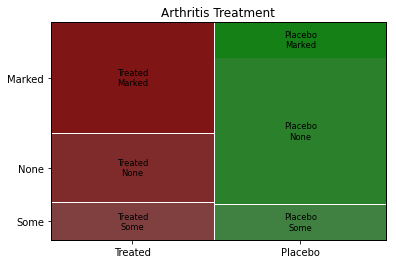

In [5]:
mosaic(ra, ['Treatment','Improved'], title = "Arthritis Treatment")
plt.show() #default mosaic plot 

### (Bonus) question

What fundamental error does the default plot from `pandas` make?

### Answer

1. It uses red and green as the only colours which likely to be difficult for people with colour blindness. 5% of the population is colour blind
2. It has not respected the implicit ordering of response values. (None > some > marked) 
3. The line between marked and none can't be seen on the placebo side

The figure below makes the pattern in the data far clearer (at the expense of few lines of code).

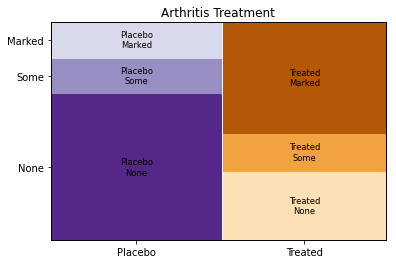

In [6]:
#mosaic plot, detailed visualisation customisation 
ra['Improved'] = pd.Series(
    pd.Categorical(ra.Improved, 
                 categories=['None','Some','Marked'],  #tell the graph that there is a order and what the order is 
                 ordered=True))

props = lambda key: {'color': 'r' if 'a' in key else 'gray'}
props = {}
props[('Treated','Marked')] = {'color': '#b35806'}
props[('Treated','Some')] = {'color': '#f1a340'}
props[('Treated','None')] = {'color': '#fee0b6'}
props[('Placebo','Marked')] = {'color': '#d8daeb'}
props[('Placebo','Some')] = {'color': '#998ec3'}
props[('Placebo','None')] = {'color': '#542788'}

mosaic(ra, ['Treatment','Improved'], title = "Arthritis Treatment", properties=props)
plt.show()

### Question

For this trial, what was the null hypothesis?

### Answer

The null hypothesis is that any change in symptoms is independent of whether the patient recieved the treatment or a placebo. Or in other words, an equal amount of the amount of arthritis treatment for both people who got placebo and treated. 

### Question

Is it valid to use a $\chi^{2}$-test for this data?

### Answer

We have more than 5 counts in each cell of the table, so we can use the $\chi^{2}$-test. Be warned, some statisticians would prefer that you had at least 10 in each cell. 

### Question

How many degrees of freedom are there in this data? Degree of freedom of chi-squared tests

### Answer

Two, because there are two rows of three columns and $(2 - 1)(3 - 1) = 2$.

### Question

Perform a $\chi^{2}$-test on the contingency table; are treatment and changes in symptoms independent?

### Answer

The following code carries out the test and allows us to reject the null hypothesis.

In [7]:
#manually calculate chi-squared and p value by hand 
t = outcome_tbl.to_numpy()
col_sums = np.sum(t, axis=0)
row_sums = np.sum(t, axis=1)
total_sum = t.sum()

my_et = np.zeros((2,3))
for ix in range(2):
    for jx in range(3):
        my_et[ix,jx] = col_sums[jx] * row_sums[ix] / total_sum

print("Observed values")
print(t)
print("Expected values under null")
print(my_et)
print("Chi-squared statistic")
my_chi = (np.power(t - my_et, 2) / my_et).sum()
print(my_chi)
print("p-value")
print(1 - scipy.stats.chi2.cdf(my_chi, df=2))

Observed values
[[ 7 29  7]
 [21 13  7]]
Expected values under null
[[14.33333333 21.5         7.16666667]
 [13.66666667 20.5         6.83333333]]
Chi-squared statistic
13.055019852524108
p-value
0.0014626434089526352


In [8]:
# use chi^2 contigency function from scipy.stats
chi2, p, dof, expected = scipy.stats.chi2_contingency(outcome_tbl.to_numpy())
print(chi2) #chi^2
print(p) #p value > small p value 
print(dof) #degree of freedom
print(expected) #expected value under null 

13.055019852524108
0.0014626434089526504
2
[[14.33333333 21.5         7.16666667]
 [13.66666667 20.5         6.83333333]]


### (Bonus) Question

What can we conclude from this hypothesis test? Why do we need to randomise the treatment?

### Answer

- We can conclude that treatment and changes in symptoms are not independent > however we cannot conclude treatment causes changes in symptoms
- Randomisation helps avoid confounding factors which lends more credibility to the conclusion that the treatment improves the condition. 

Note that a proper treatment of *causality* goes well beyond the scope of this course, but recall that randomised controlled trials provide very very high quality evidence.*

Recall from earlier notebooks the function `estimate_and_ci` which computes the probability of success in repeated Bernoulli trials and the $95\%$ confidence interval on this estimate.

In [9]:
def estimate_and_ci(num_trials, num_success):
    p_hat = num_success / num_trials
    z = 1.96
    delta = z * np.sqrt(p_hat * (1 - p_hat) / num_trials)
    return (p_hat,(p_hat - delta, p_hat + delta))

The functions `rand_small_table` and `rand_big_table` defined below return random datasets of the same shape as out arthritis dataset under the null hypothesis in which the outcome is independent of treatment. The `rand_small_table` returns data from a smaller cohort and the `rand_big_table` returns data from a larger cohort. 

In [10]:
_, _, _, expected = scipy.stats.chi2_contingency(outcome_tbl.to_numpy())

def rand_small_table(): #get small table of random dataset 
    x = np.array(0)
    while x.min() < 1:
        x = scipy.stats.poisson.rvs(mu = np.array(0.5) * expected)
    return x

def rand_big_table(): #get big table of random dataset 
    x = np.array(0)
    while x.min() < 1:
        x = scipy.stats.poisson.rvs(mu = np.array(1.5) * expected)
    return x

### Question

Using the functions `estimate_and_ci`, and `rand_small_table` and `rand_big_table`, demonstrate how the $\chi^{2}$-test will fail if the cell values are too small i.e. there has to be enough values in each row/column for the chi^2 test to be fair.

### Answer

The false positive test suggests that the test will not be powerful enough on smaller tables.

In [11]:
num_trials = 10000
false_pos_count = 0
for _ in range(num_trials):
    x = rand_small_table()
    _, p, _, _ = scipy.stats.chi2_contingency(x)
    if p < 0.1:
        false_pos_count+=1 
print(estimate_and_ci(num_trials, false_pos_count))

(0.0839, (0.07846613939391155, 0.08933386060608846))
